# Task 2 - LSTM for time series classification

In [0]:
import numpy as np
import pandas as pd
import re
import os

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

In [129]:
# GPU
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.2 GB  | Proc size: 3.0 GB
GPU RAM Free: 10952MB | Used: 489MB | Util   4% | Total 11441MB


## Data import & EDA

In [4]:
files.upload()

Saving Ambient_Living_180.csv to Ambient_Living_180.csv
Saving Ambient_Living_181.csv to Ambient_Living_181.csv
Saving Ambient_Living_182.csv to Ambient_Living_182.csv
Saving Ambient_Living_183.csv to Ambient_Living_183.csv
Saving Ambient_Living_184.csv to Ambient_Living_184.csv
Saving Ambient_Living_185.csv to Ambient_Living_185.csv
Saving Ambient_Living_186.csv to Ambient_Living_186.csv
Saving Ambient_Living_187.csv to Ambient_Living_187.csv
Saving Ambient_Living_188.csv to Ambient_Living_188.csv
Saving Ambient_Living_189.csv to Ambient_Living_189.csv
Saving Ambient_Living_190.csv to Ambient_Living_190.csv
Saving Ambient_Living_191.csv to Ambient_Living_191.csv
Saving Ambient_Living_192.csv to Ambient_Living_192.csv
Saving Ambient_Living_193.csv to Ambient_Living_193.csv
Saving Ambient_Living_194.csv to Ambient_Living_194.csv
Saving Ambient_Living_195.csv to Ambient_Living_195.csv
Saving Ambient_Living_196.csv to Ambient_Living_196.csv
Saving Ambient_Living_197.csv to Ambient_Living_

{'Ambient_Living_180.csv': b'Sensor 1,Sensor 2,Sensor 3,Sensor 4\r\n-0.31818,-0.022222,-0.33333,-0.10638\r\n-0.31818,0.2,-0.2,-0.10638\r\n-0.31818,-0.37778,-0.2,-0.14894\r\n-0.31818,0.2,-0.33333,-0.10638\r\n-0.31818,0.066667,-0.2,-0.10638\r\n-0.31818,0.066667,-0.066667,-0.06383\r\n-0.31818,0.066667,-0.022222,0.021277\r\n-0.31818,0.066667,0.022222,0.021277\r\n-0.31818,-0.46667,-0.066667,0.021277\r\n-0.5,-0.066667,-0.066667,0.021277\r\n-0.090909,-0.15556,-0.2,-0.44681\r\n-0.090909,-0.066667,-0.33333,-0.44681\r\n-0.13636,-0.066667,-0.2,-0.31915\r\n-0.13636,0.11111,-0.2,-0.31915\r\n-0.5,0.24444,-0.15556,0.14894\r\n-0.5,0.066667,-0.24444,0.14894\r\n0.090909,-0.33333,-0.2,-0.06383\r\n0.090909,0.066667,-0.2,-0.06383\r\n0,0.11111,-0.2,-0.06383\r\n-0.13636,0.066667,-0.33333,-0.10638\r\n-0.13636,-0.066667,-0.11111,0.021277\r\n-0.13636,-0.77778,-0.15556,-0.06383\r\n-0.13636,0.15556,-0.2,-0.06383\r\n0.045455,-0.066667,-0.066667,0.021277\r\n0.045455,-0.022222,0.066667,0.021277\r\n0.045455,-0.33333,

In [5]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'(?P<seq_id>\d+).csv'
data_files = list(filter(lambda s: re.match(data_file_pattern, s) is not None, os.listdir()))
N_FILES = len(data_files)
N_FILES

37

In [6]:
seq_ids = sorted(int(re.match(data_file_pattern, file_name).group('seq_id')) for file_name in data_files)
print(seq_ids)

[180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]


In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [8]:
seq_id = seq_ids[0]
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.31818,-0.022222,-0.33333,-0.10638
1,-0.31818,0.200000,-0.20000,-0.10638
2,-0.31818,-0.377780,-0.20000,-0.14894
3,-0.31818,0.200000,-0.33333,-0.10638
4,-0.31818,0.066667,-0.20000,-0.10638


In [9]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,68.000000,68.000000,68.000000,68.000000
mean,-0.283423,-0.356210,0.108497,0.125157
std,0.254977,0.327455,0.367292,0.287519
min,-1.000000,-1.000000,-0.733330,-0.446810
25%,-0.454550,-0.600000,-0.200000,-0.106380
50%,-0.318180,-0.466670,0.066667,0.148940
75%,-0.079546,-0.066667,0.388890,0.276600
max,0.227270,0.244440,0.777780,0.659570


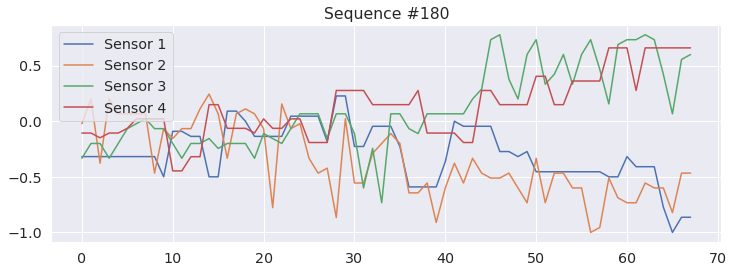

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [11]:
# load targets (class labels) for available sequences (only those which have been uploaded)
targets = load_file('target', True).iloc[np.array(seq_ids)-1]
targets.head()

,#sequence_ID,class_label
179,180,1
180,181,1
181,182,1
182,183,1
183,184,1


In [12]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

 1    24
-1    13
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
# load data for the available sequences
all_data = [load_file(i) for i in seq_ids]


In [15]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data]
descr['n_features'] = [d.shape[1] for d in all_data]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
180,1,68,4
181,1,65,4
182,1,56,4
183,1,60,4
184,1,65,4


In [16]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,37.000000,37.0
mean,54.891892,4.0
std,10.027140,0.0
min,37.000000,4.0
20%,42.400000,4.0
40%,56.000000,4.0
50%,59.000000,4.0
60%,61.600000,4.0
80%,64.000000,4.0
max,68.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [17]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

64

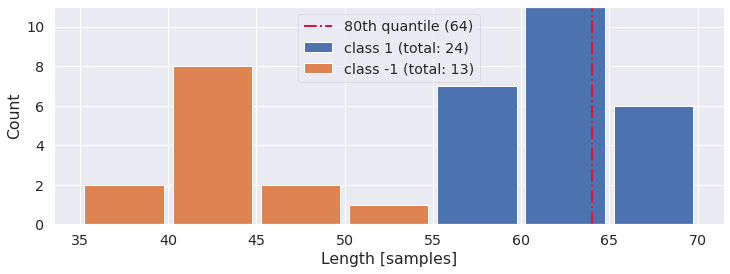

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[0].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

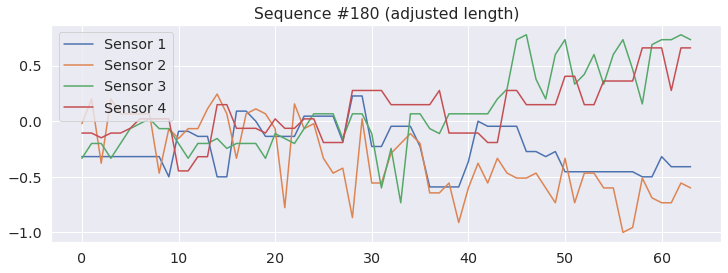

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm(my_lstm_units, my_lr):
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(my_lstm_units, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=my_lr)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=10)
sk_params = dict(**fit_params, my_lstm_units=256, my_lr=0.001)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
kc = KerasClassifier(make_lstm, **sk_params)


In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


In [0]:
# run the cross-validation
# scores = cross_val_score(KerasClassifier(make_lstm, **sk_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


In [0]:
# scores

## Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {'my_lr': [0.001, 0.01, 0.1], 'batch_size': [N_FILES, N_FILES//3, N_FILES//6], 'my_lstm_units': [128, 256]}

In [29]:
gcv = GridSearchCV(KerasClassifier(make_lstm, **fit_params), param_grid=param_grid, cv=kf, scoring=scorer)
gcv

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f06e43880f0>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [37, 12, 6], 'my_lr': [0.001, 0.01, 0.1],
                         'my_lstm_units': [128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7f066607a268>, verbose=0)

In [0]:
gcv.fit(all_data_prep, all_labels)

In [147]:
gcv_results = pd.DataFrame(gcv.cv_results_['params'])
codes = gcv_results.columns

gcv_results['mean_test_score'] = gcv.cv_results_['mean_test_score']
gcv_results.sort_values('mean_test_score', ascending=False, inplace=True)

gcv_results


,batch_size,my_lr,my_lstm_units,mean_test_score
12,6,0.001,128,0.975000
13,6,0.001,256,0.950000
6,12,0.001,128,0.941667
7,12,0.001,256,0.875000
1,37,0.001,256,0.875000
14,6,0.010,128,0.850000
16,6,0.100,128,0.816667
8,12,0.010,128,0.791667
10,12,0.100,128,0.791667
11,12,0.100,256,0.791667


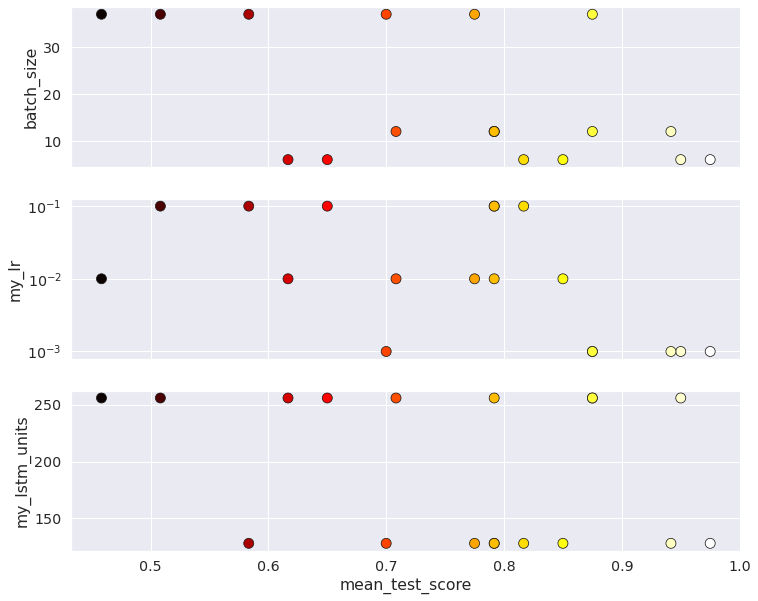

In [146]:
fig, axes = plt.subplots(3, 1, sharex='all', figsize=(12, 10))
for i, ax in enumerate(axes):
    sns.scatterplot(data=gcv_results, x='mean_test_score', y=codes[i], ax=ax, hue='mean_test_score',
                    palette='hot', legend=None, edgecolor='k', s=100)
  
axes[1].set_yscale('log')

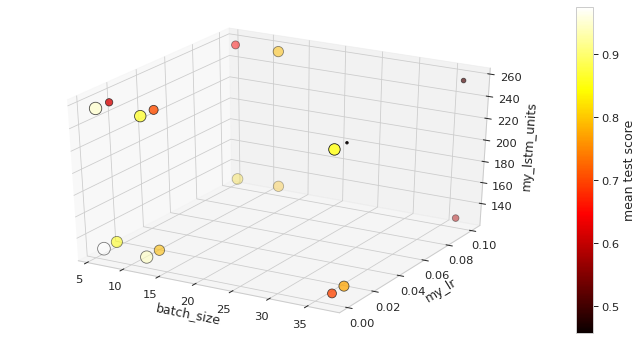

In [148]:
from mpl_toolkits.mplot3d import Axes3D


with sns.plotting_context('paper', font_scale=1.3):
    sns.set_style('whitegrid')

    fig = plt.figure(figsize=(12,6), facecolor=(1, 1, 1))

    ax = fig.add_subplot(111, projection='3d')


    mts = gcv_results['mean_test_score']

    p = ax.scatter(*tuple(gcv_results[code] for code in codes),
                  c=mts, marker='o', cmap='hot', edgecolor='k',
                  s=300*(mts-0.95*mts.min()))
    
    cbar = fig.colorbar(p)
    cbar.set_label('mean test score', rotation=90)


    ax.set_xlabel(codes[0])
    ax.set_ylabel(codes[1])
    ax.set_zlabel(codes[2])
